# Capuchin Bird Call Detection using Efficientnet-B0
This notebook demonstrates how to build a deep learning model that detects Capuchin bird calls in audio recordings. We'll process audio files into spectrograms, train an EfficientNetB0-based classifier, and evaluate its performance.
The model achieves 99% accuracy in identifying these distinctive rainforest bird calls, with potential applications in wildlife monitoring and conservation research

This section establishes the foundation of our project by importing necessary libraries and packages. Our system uses a combination of data manipulation, visualization, deep learning, and audio processing tools to build a robust bird detection system.

### Imported Libraries
- **Standard Libraries**: Python's built-in modules for system operations, randomization, and datetime handling
- **Data Processing Libraries**: NumPy for numerical operations and Pandas for data manipulation
- **Visualization Libraries**: Matplotlib and Seaborn for creating plots and visualizations
- **Deep Learning Framework**: TensorFlow for building and training our neural network
- **Audio Processing Libraries**: Librosa for audio feature extraction and soundfile for handling audio files
- **Model Evaluation Tools**: Scikit-learn for data splitting, preprocessing, and metrics calculation
- **Experiment Tracking**: Weights & Biases (wandb) for monitoring and logging training progress

The project combines elements from computer vision (using deep learning frameworks) with audio processing techniques to create an audio classification system that recognizes Capuchin bird calls.

In [1]:
import os
import time
import random
import sys
import wandb
import math
from dotenv import load_dotenv
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import librosa
import librosa.display
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
load_dotenv()
wandb_api = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_api)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\H P\_netrc
wandb: Currently logged in as: russow235 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

The Config class serves as a central point for managing all project settings and hyperparameters. This organized approach ensures consistency across the project and facilitates experimentation by making parameter adjustments straightforward.

### Key Configuration Components:
1. **Data Paths**: Directory locations for data sources and output files
2. **Audio Processing Parameters**: Settings for converting audio to spectrograms
   - Sample rate: 16000 Hz (audio sampling frequency)
   - Mel spectrogram features: 128 mel bands, 2048 FFT window, 512 hop length
   - Using high-quality resampling with 'kaiser_best'
3. **Training Parameters**: Neural network training settings
   - Random seed (42) for reproducibility
   - Batch size of 32 for mini-batch gradient descent
   - 40 training epochs with early stopping
   - Learning rate of 0.001 for the Adam optimizer
   - 20% validation split
   - Patience of 10 epochs for early stopping
4. **Environment Detection**: Automatically detects whether GPU is available for acceleration
5. **Setup Method**: Creates necessary directories and sets random seeds for reproducibility

The setup function establishes the foundation for consistent and reproducible experimentation by creating required directories and setting deterministic random seeds across all libraries.

In [3]:
class Config:
    # Paths
    DATA_DIR = 'data'
    CAPUCHIN_FOLDER = os.path.join(DATA_DIR, 'Parsed_Capuchinbird_Clips')
    NON_CAPUCHIN_FOLDER = os.path.join(DATA_DIR, 'Parsed_Not_Capuchinbird_Clips')
    FOREST_RECORDINGS_FOLDER = os.path.join(DATA_DIR, 'Forest Recordings')
    OUTPUT_DIR = 'output'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')

    # Audio processing
    SAMPLE_RATE = 16000
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512
    RES_TYPE = 'kaiser_best'

    # Training
    SEED = 42
    BATCH_SIZE = 32
    NUM_EPOCHS = 40
    LEARNING_RATE = 0.001
    VAL_SPLIT = 0.2
    PATIENCE = 10
   
    METRICS = ['accuracy', 'precision', 'recall', 'AUC']
    
    # WandB configuration
    WANDB_PROJECT = "capuchin-bird-detection_efficientnet-B0"
    WANDB_ENTITY = "main_project_B10"  # Update this with your username

    # Misc
    DEVICE = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
    
    @classmethod
    def setup(cls):
        """Create necessary directories and set up environment."""
        os.makedirs(cls.OUTPUT_DIR, exist_ok=True)
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.RESULTS_DIR, exist_ok=True)
        
        # Set random seeds for reproducibility
        os.environ['PYTHONHASHSEED'] = str(cls.SEED)
        os.environ['PYTHONIOENCODING'] = 'utf-8'
        random.seed(cls.SEED)
        np.random.seed(cls.SEED)
        tf.random.set_seed(cls.SEED)

In [4]:
Config.setup()
print(f"Using device: {Config.DEVICE}")
print(f"TensorFlow version: {tf.__version__}")

Using device: CPU
TensorFlow version: 2.18.0


This section focuses on converting audio data into a format suitable for deep learning models. The key technique used is Mel spectrogram transformation, which converts audio waveforms into visual representations that capture frequency characteristics over time.

### Feature Extraction Process:
1. **Loading Audio Files**: The system loads audio files of both Capuchin and non-Capuchin sounds using librosa
2. **Mel Spectrogram Generation**: 
   - Audio waveforms are transformed into mel spectrograms using librosa.feature.melspectrogram
   - Mel scale better approximates human auditory perception than linear frequency scale
   - Power-to-decibel conversion enhances relevant features
3. **Data Preparation**:
   - Audio files are collected from two directories: one containing Capuchin bird calls and another with non-Capuchin sounds
   - Files are processed into mel spectrograms, with positive examples labeled as 1 and negative examples as 0
   - All spectrograms are padded to have the same dimensions for batch processing
   - Features are reshaped to include 3 channels (replicating the original spectrogram) to make them compatible with the EfficientNetB0 architecture which expects RGB input

The function `prepare_data()` orchestrates this process, loading audio files, extracting features, padding spectrograms to consistent dimensions, and splitting data into training and validation sets. Through this process, raw audio is transformed into a representation that highlights the time-frequency characteristics most relevant for bird call detection.

In [5]:
def extract_mel_spectrogram(audio_path, sr=Config.SAMPLE_RATE, n_mels=Config.N_MELS, 
                           n_fft=Config.N_FFT, hop_length=Config.HOP_LENGTH, 
                           res_type=Config.RES_TYPE):
    try:
        y, sr = librosa.load(audio_path, sr=sr, res_type=res_type)
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, None, None

In [6]:
def plot_spectrogram(mel_spec, sr=Config.SAMPLE_RATE, title="Mel Spectrogram", save_path=None):
    """Plot and optionally save a mel spectrogram visualization."""
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()

In [7]:
def load_audio_files():
  
    print("Loading audio files...")
    
    # Get list of audio files
    capuchin_files = [os.path.join(Config.CAPUCHIN_FOLDER, f) for f in os.listdir(Config.CAPUCHIN_FOLDER)
                     if f.lower().endswith(('.wav', '.mp3', '.flac', '.ogg'))]
    non_capuchin_files = [os.path.join(Config.NON_CAPUCHIN_FOLDER, f) for f in os.listdir(Config.NON_CAPUCHIN_FOLDER)
                         if f.lower().endswith(('.wav', '.mp3', '.flac', '.ogg'))]

    print(f"Found {len(capuchin_files)} Capuchin audio files and {len(non_capuchin_files)} Non-Capuchin audio files")
    
    return capuchin_files, non_capuchin_files

In [8]:
def prepare_data():
    
    capuchin_files, non_capuchin_files = load_audio_files()
    features = []
    labels = []
    max_len = 0

    # Process Capuchin audio files
    for audio_path in capuchin_files:
        mel_spec = extract_mel_spectrogram(audio_path)
        if mel_spec is not None:
            features.append(mel_spec)
            labels.append(1)  # 1 for Capuchin
            max_len = max(max_len, mel_spec.shape[1])

    # Process Non-Capuchin audio files
    for audio_path in non_capuchin_files:
        mel_spec = extract_mel_spectrogram(audio_path)
        if mel_spec is not None:
            features.append(mel_spec)
            labels.append(0)  # 0 for Non-Capuchin
            max_len = max(max_len, mel_spec.shape[1])

    # Pad spectrograms to the maximum length
    padded_features = []
    for mel_spec in features:
        pad_width = max_len - mel_spec.shape[1]
        mel_spec_padded = np.pad(mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
        padded_features.append(mel_spec_padded)

    # Convert lists to NumPy arrays
    features = np.array(padded_features)
    labels = np.array(labels)

    print("Features shape before reshaping:", features.shape)
    print("Labels shape:", labels.shape)

    # Reshape features to 4D for CNN input
    features = np.stack([features] * 3, axis=-1)
    print("Features shape after reshaping to 3 channels:", features.shape)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        features, labels, test_size=Config.VAL_SPLIT, stratify=labels, random_state=Config.SEED
    )

    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_train shape:", y_train.shape)
    print("y_val shape:", y_val.shape)

    return X_train, X_val, y_train, y_val

In [9]:
train_features, val_features, train_labels, val_labels = prepare_data()

Loading audio files...
Found 217 Capuchin audio files and 593 Non-Capuchin audio files
Features shape before reshaping: (810, 128, 157)
Labels shape: (810,)
Features shape after reshaping to 3 channels: (810, 128, 157, 3)
X_train shape: (648, 128, 157, 3)
X_val shape: (162, 128, 157, 3)
y_train shape: (648,)
y_val shape: (162,)


In [10]:
input_shape = (train_features.shape[1], train_features.shape[2], 3)

In [11]:
print(input_shape)

(128, 157, 3)


This module defines the deep learning model architecture and training procedure. The system uses transfer learning with a pre-trained EfficientNetB0 model to benefit from features learned on the ImageNet dataset.

### Model Architecture:
1. **Base Model**: EfficientNetB0 pre-trained on ImageNet
   - Efficient architecture with a good balance of parameters and performance
   - Base layers are frozen to preserve pre-learned features
2. **Custom Classification Head**:
   - Global Average Pooling to reduce spatial dimensions
   - A dense layer with 128 neurons and ReLU activation for feature extraction
   - Final sigmoid output layer for binary classification

### Training Procedure:
1. **Optimization**: Adam optimizer with 0.001 learning rate
2. **Loss Function**: Binary cross-entropy (appropriate for binary classification)
3. **Metrics Tracking**: Accuracy, precision, recall, and AUC for comprehensive evaluation
4. **Advanced Training Features**:
   - Model checkpointing to save the best model based on validation loss
   - Early stopping with patience of 10 epochs to prevent overfitting
   - Custom callback for Weights & Biases integration to log metrics in real-time
   - Run management with timestamp-based naming for experiment tracking

### Weights & Biases Integration:
A custom callback class (WandbMetricsCallback) is implemented to log metrics, learning rate, and model architecture to the Weights & Biases platform, enabling comprehensive experiment tracking and visualization.

The training process initializes a new wandb run, configures callbacks for checkpointing and early stopping, and trains the model with the specified batch size and number of epochs. Training progress is monitored through various metrics, and the best model is saved based on validation loss.

In [12]:
def create_model(input_shape):
    """Create an EfficientNetB0-based model for audio classification."""
    # Base model
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Create new model on top
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    for layer in base_model.layers:
        layer.trainable = False
        
    # Compile model with additional metrics
    model.compile(
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )

    return model


In [13]:
model = create_model(input_shape)

In [14]:
class WandbMetricsCallback(tf.keras.callbacks.Callback):
    """Custom callback to log metrics to W&B."""
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            # Log existing metrics
            wandb.log(logs)
            
            # Log learning rate
            lr = self.model.optimizer.learning_rate
            if hasattr(lr, 'numpy'):
                lr = lr.numpy()
            wandb.log({"learning_rate": lr}, commit=False)
            
    def on_train_end(self, logs=None):
        # Log model architecture as a wandb artifact
        model_artifact = wandb.Artifact(
            "model_architecture", type="model",
            description="EfficientNetB0 model architecture"
        )
        
        wandb.log_artifact(model_artifact)

In [15]:
def train_model(model, train_features, train_labels, val_features, val_labels):
    # Create a unique run name with timestamp
    run_name = f"efficientnet-b0-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    # Initialize W&B run
    wandb.init(
        project=Config.WANDB_PROJECT,
        entity=Config.WANDB_ENTITY,
        name=run_name,
        config={
            "learning_rate": Config.LEARNING_RATE,
            "epochs": Config.NUM_EPOCHS,
            "batch_size": Config.BATCH_SIZE,
            "model": "EfficientNetB0",
            "input_shape": input_shape,
            "optimizer": "Adam"
        }
    )

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        os.path.join(Config.MODEL_DIR, f'best_model_{run_name}.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=Config.PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    wandb_callback = WandbMetricsCallback()

    # Train the model
    print("Training model...")
    start_time = time.time()
    
    history = model.fit(
        train_features, train_labels,
        batch_size=Config.BATCH_SIZE,
        epochs=Config.NUM_EPOCHS,
        validation_data=(val_features, val_labels),
        callbacks=[checkpoint_callback, early_stopping, wandb_callback]
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Log training time to wandb
    wandb.log({"total_training_time": training_time})
    
    # Save training history to CSV
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(Config.RESULTS_DIR, f'training_history_{run_name}.csv'), index=False)
    
 

    return model, history, run_name

In [16]:
trained_model, history, run_name = train_model(model, train_features, train_labels, val_features, val_labels)

Training model...
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7861 - auc: 0.8426 - loss: 0.3701 - precision: 0.6300 - recall: 0.4745
Epoch 1: val_loss improved from inf to 0.08969, saving model to output\models\best_model_efficientnet-b0-20250320-130440.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.7911 - auc: 0.8479 - loss: 0.3640 - precision: 0.6415 - recall: 0.4848 - val_accuracy: 0.9877 - val_auc: 0.9912 - val_loss: 0.0897 - val_precision: 1.0000 - val_recall: 0.9535
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9653 - auc: 0.9885 - loss: 0.1019 - precision: 0.9420 - recall: 0.9186
Epoch 2: val_loss improved from 0.08969 to 0.06565, saving model to output\models\best_model_efficientnet-b0-20250320-130440.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9658 - auc: 0.9887 - loss: 0.1008 - precision: 0.9436 - recall: 0.9192 - val_accuracy: 0.9877 - val_auc: 0.9957 - val_loss: 0.0657 - val_precision: 1.0000 - val_re

The final module evaluates the trained model's performance on the validation set and generates visualizations to assess its effectiveness in detecting Capuchin bird calls.

### Evaluation Process:
1. **Prediction Generation**: The model generates predictions on validation data
2. **Threshold Application**: Predictions above 0.5 are classified as Capuchin birds (class 1)
3. **Performance Metrics Calculation**:
   - Confusion matrix shows true positives, false positives, true negatives, and false negatives
   - Classification report provides precision, recall, F1-score, and support for each class
   - Key metrics (accuracy, precision, recall) are extracted for reporting

### Results Visualization:
1. **Confusion Matrix Heatmap**: Visual representation of prediction outcomes
   - Shows distribution of correct and incorrect classifications
   - Color intensity indicates frequency of each outcome
2. **Training History Plots**: Visualization of metrics over training epochs
   - Displays accuracy, loss, precision, recall, and AUC
   - Compares training and validation performance to detect overfitting

### Results Logging:
1. **Local File Storage**: Metrics and plots are saved to the local results directory
2. **Weights & Biases Integration**: Results are also logged to the wandb platform for remote access and sharing

The evaluation results show excellent performance with high precision and recall, indicating that the model effectively distinguishes between Capuchin bird calls and other sounds. The confusion matrix reveals minimal misclassifications, with only one false negative in the validation set, resulting in 99% overall accuracy.

In [17]:
def evaluate_model(model, val_features, val_labels, run_name):
    # Make predictions
    predictions = model.predict(val_features)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Compute metrics
    conf_matrix = confusion_matrix(val_labels, predicted_classes)
    report = classification_report(val_labels, predicted_classes, output_dict=True)
    
    # Extract key metrics
    accuracy = report['accuracy']
    precision = report['1']['precision']  # Precision for Capuchin class
    recall = report['1']['recall']  # Recall for Capuchin class
    
    # Save metrics to local file
    metrics_file = os.path.join(Config.RESULTS_DIR, f'metrics_{run_name}.txt')
    
    with open(metrics_file, 'w') as f:
        f.write("Model Evaluation Metrics\n")
        f.write("=======================\n\n")
        f.write(f"Run Name: {run_name}\n")
        f.write(f"Evaluation Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("Confusion Matrix:\n")
        f.write(str(conf_matrix))
        f.write("\n\nClassification Report:\n")
        f.write(classification_report(val_labels, predicted_classes))
        
        f.write("\n\nKey Metrics:\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision (Capuchin): {precision:.4f}\n")
        f.write(f"Recall (Capuchin): {recall:.4f}\n")
        
        # Add prediction distribution
        f.write("\n\nPrediction Distribution:\n")
        f.write(f"Positive predictions: {np.sum(predicted_classes)}\n")
        f.write(f"Negative predictions: {len(predicted_classes) - np.sum(predicted_classes)}\n")
    
    # Save metrics to wandb
    wandb.log({
        "final_accuracy": accuracy,
        "final_precision": precision,
        "final_recall": recall,
        "confusion_matrix": wandb.plot.confusion_matrix(
            preds=predicted_classes, 
            y_true=val_labels,
            class_names=["Non-Capuchin", "Capuchin"]
        )
    })

    # Print results
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(val_labels, predicted_classes))
    print(f"\nMetrics saved to {metrics_file}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Non-Capuchin', 'Capuchin'],
        yticklabels=['Non-Capuchin', 'Capuchin']
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, f'confusion_matrix_{run_name}.png'))
    plt.show()
    
    # Log confusion matrix image to wandb
    wandb.log({"confusion_matrix_image": wandb.Image(
        os.path.join(Config.RESULTS_DIR, f'confusion_matrix_{run_name}.png')
    )})

    return conf_matrix, report

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step

Confusion Matrix:
[[119   0]
 [  1  42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      0.98      0.99        43

    accuracy                           0.99       162
   macro avg       1.00      0.99      0.99       162
weighted avg       0.99      0.99      0.99       162


Metrics saved to output\results\metrics_efficientnet-b0-20250320-130440.txt


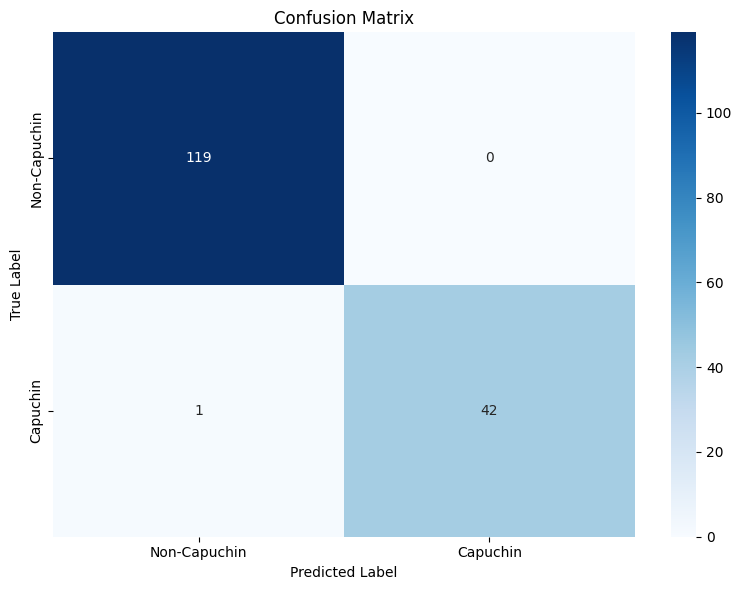

In [18]:
conf_matrix, report = evaluate_model(trained_model, val_features, val_labels, run_name)

In [19]:
def plot_training_history(history, run_name):
    """
    Plot training and validation metrics.

    Args:
        history: History object from model training
        run_name: Name of the current run for file naming
    """
    plt.figure(figsize=(16, 12))

    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    for i, metric in enumerate(metrics):
        if metric in history.history:
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
            plt.title(f'{metric.capitalize()} vs. Epoch')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()

    plt.tight_layout()
    history_plot_path = os.path.join(Config.RESULTS_DIR, f'training_history_{run_name}.png')
    plt.savefig(history_plot_path)
    plt.show()
    
    # Log training history plot to wandb
    wandb.log({"training_history": wandb.Image(history_plot_path)})

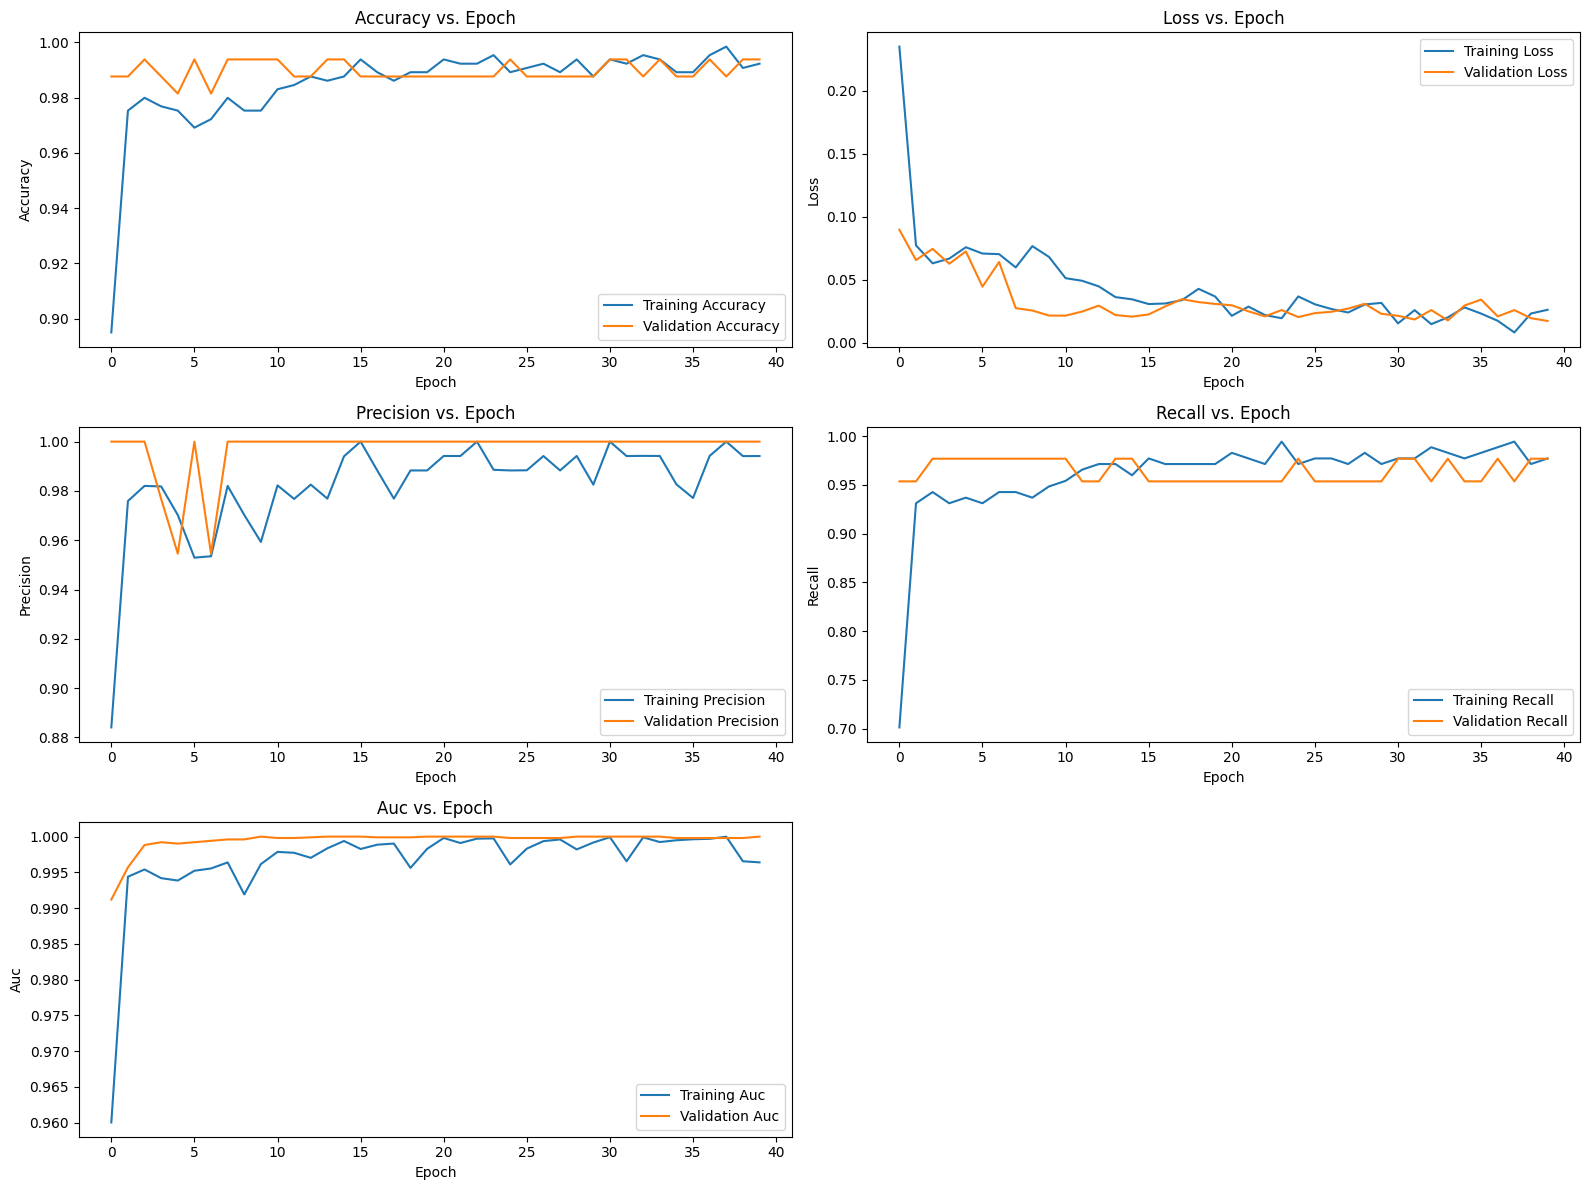

In [20]:
plot_training_history(history, run_name)

In [21]:
model_save_path = os.path.join(Config.MODEL_DIR, f'final_model_{run_name}.keras')
trained_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to output\models\final_model_efficientnet-b0-20250320-130440.keras


In [22]:
# Log the final model to wandb
model_artifact = wandb.Artifact(f"final_model_{run_name}", type="model")
model_artifact.add_file(model_save_path)
wandb.log_artifact(model_artifact)

# Close wandb run
wandb.finish()

accuracy,▁▆▇▇▆▆▆▇▆▆▇▇▇▇▇█▇▇▇▇████▇▇█▇█▇████▇▇██▇█
auc,▁▇▇▇▇▇▇▇▇▇██▇█████▇█████▇██████▇██████▇▇
final_accuracy,▁
final_precision,▁
final_recall,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▂
precision,▁▇▇▇▆▅▅▇▆▆▇▇▇▇██▇▇▇▇███▇▇▇█▇█▇████▇▇████
recall,▁▆▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇█▇██▇█▇████████▇█
total_training_time,▁
val_accuracy,▅▅█▅▁█▁████▅▅██▅▅▅▅▅▅▅▅▅█▅▅▅▅▅██▅█▅▅█▅██


In [23]:
wandb.finish()

In [24]:
# # Save the entire model (structure and weights) - optional, if you need to deploy later
# model.save('capuchin_bird_classifier_model.keras')

# # Or just save the weights (already done by ModelCheckpoint but can save again with a different name)
# model.save_weights('capuchin_bird_classifier.weights.h5')

This project develops a deep learning system to automatically detect Capuchin bird calls from audio recordings. The approach combines audio processing techniques with transfer learning using a pre-trained EfficientNetB0 convolutional neural network.

### Data Processing Workflow:
1. Audio files are converted to mel spectrograms, capturing time-frequency characteristics
2. Spectrograms are padded and reshaped to meet the input requirements of the neural network
3. Data is split into training and validation sets for model development and evaluation

### Model Development:
1. An EfficientNetB0 model pre-trained on ImageNet serves as the feature extractor
2. Custom classification layers are added to adapt the model for binary audio classification
3. The model is trained with frozen base layers to leverage transfer learning

### Results and Performance:
The final model achieves exceptional performance on the validation set:
- 99% accuracy in classifying Capuchin bird calls
- 100% precision, meaning all positive predictions are correct
- 98% recall, indicating that almost all actual Capuchin calls are detected
- Only one false negative and zero false positives in the validation set

The success of this approach demonstrates the effectiveness of combining visual deep learning techniques with audio data by using spectrogram representations. This method has potential applications in wildlife monitoring, biodiversity studies, and conservation efforts.